## Regression project: Medical Insurance Price Prediction

1. Load required libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to make sure the plots are shown in the notebook
%matplotlib inline 

2. Data preparation

In [2]:
df=pd.read_csv("data.csv")
df

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000


In [3]:
import re

def convert_to_snake_case(column_name):
    # Add a space before capital letters and convert to lowercase
    spaced = re.sub(r'(?<!^)(?=[A-Z])', '_', column_name).lower()
    return spaced

In [4]:
df.columns = [convert_to_snake_case(col) for col in df.columns]
print(df.columns)  

Index(['age', 'diabetes', 'blood_pressure_problems', 'any_transplants',
       'any_chronic_diseases', 'height', 'weight', 'known_allergies',
       'history_of_cancer_in_family', 'number_of_major_surgeries',
       'premium_price'],
      dtype='object')


In [5]:
df.head(3)

,age,diabetes,blood_pressure_problems,any_transplants,any_chronic_diseases,height,weight,known_allergies,history_of_cancer_in_family,number_of_major_surgeries,premium_price
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000


In [6]:
df.dtypes

age                            int64
diabetes                       int64
blood_pressure_problems        int64
any_transplants                int64
any_chronic_diseases           int64
height                         int64
weight                         int64
known_allergies                int64
history_of_cancer_in_family    int64
number_of_major_surgeries      int64
premium_price                  int64
dtype: object

In [13]:
binary_features = ['diabetes','blood_pressure_problems','any_transplants', 'any_chronic_diseases', 'known_allergies', 'history_of_cancer_in_family', 'number_of_major_surgeries']
numerical_features = ['age','height','weight','premium_price']

The dataset contains a mix of binary and numerical features. The binary features include 'diabetes', 'blood_pressure_problems', 'any_transplants', 'any_chronic_diseases', 'known_allergies', 'history_of_cancer_in_family', and 'number_of_major_surgeries', which indicate the presence (1) or absence (0) of these conditions or events. The numerical features include 'age', 'height', 'weight', and 'premium_price', which are represented as integers. These numerical features provide quantitative data about the individuals, such as their age in years, height in centimeters, weight in kilograms, and the premium price of their medical insurance. This combination of binary and numerical features allows for a comprehensive analysis of the factors that may influence medical insurance prices.

In [8]:
#check for missing values
df.isnull().sum()

age                            0
diabetes                       0
blood_pressure_problems        0
any_transplants                0
any_chronic_diseases           0
height                         0
weight                         0
known_allergies                0
history_of_cancer_in_family    0
number_of_major_surgeries      0
premium_price                  0
dtype: int64

#### Exploratory data analysis (EDA)

In [22]:
df[numerical_features].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
age,986.0,41.75,13.96,18.0,30.0,42.0,53.0,66.0
height,986.0,168.18,10.10,145.0,161.0,168.0,176.0,188.0
weight,986.0,76.95,14.27,51.0,67.0,75.0,87.0,132.0
premium_price,986.0,24336.71,6248.18,15000.0,21000.0,23000.0,28000.0,40000.0


In [18]:
df["premium_price"].value_counts()

premium_price
23000    249
15000    202
28000    132
25000    103
29000     72
30000     47
35000     41
38000     34
31000     31
21000     26
19000     15
26000      7
39000      5
32000      4
24000      4
16000      3
36000      2
18000      2
34000      2
22000      1
20000      1
40000      1
27000      1
17000      1
Name: count, dtype: int64

A correlation matrix is visualized to understand the relationships between features.

<Axes: >

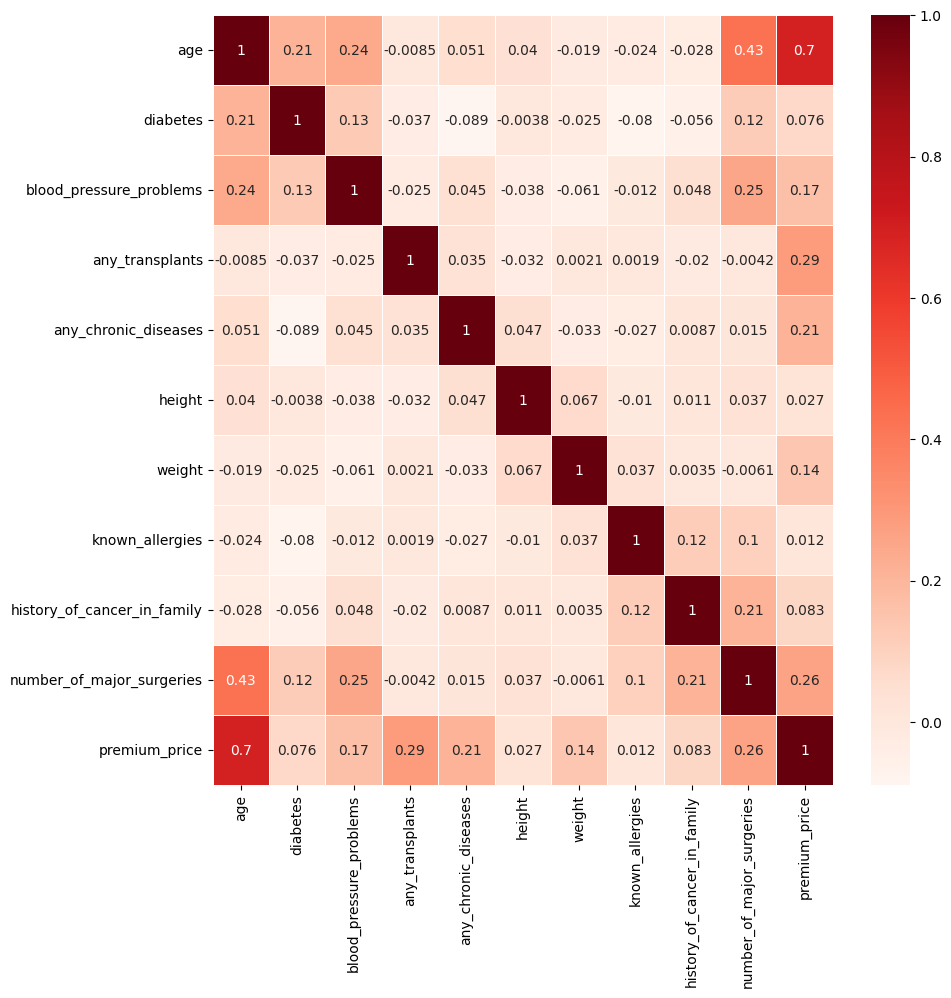

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True,linewidths=.5, cmap="Reds")

A scatter plot is used to show the relationship between height and weight.

/tmp/ipykernel_28360/3258021342.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(data=df, x="height", y="weight", s=100, palette="deep")
/tmp/ipykernel_28360/3258021342.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Distribution')


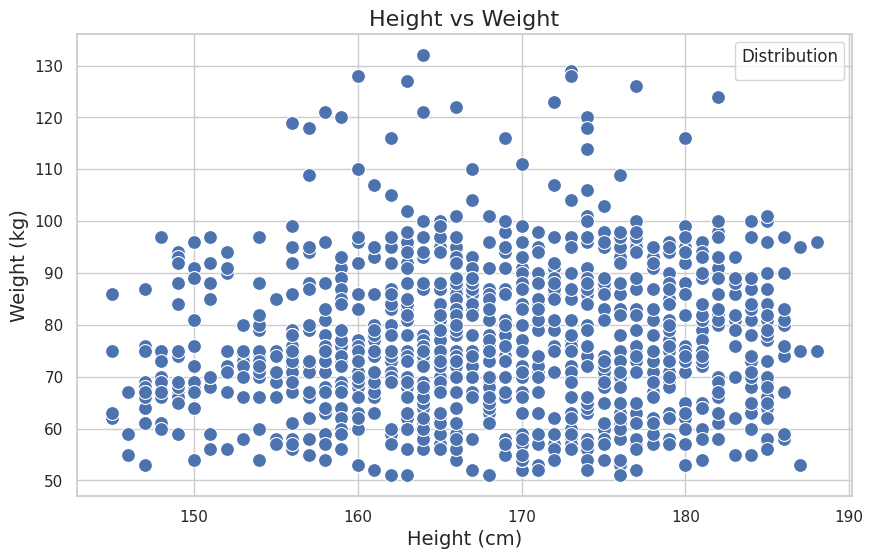

In [25]:
sns.set(style="whitegrid")

# Scatter plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df, x="height", y="weight", s=100, palette="deep")

# Başlık ve etiketler
plt.title("Height vs Weight", fontsize=16)
plt.xlabel("Height (cm)", fontsize=14)
plt.ylabel("Weight (kg)", fontsize=14)

# Efsane
plt.legend(title='Distribution')

# Grid
plt.grid(True)

# Göster
plt.show()

Distribution of price

<Axes: xlabel='premium_price', ylabel='Count'>

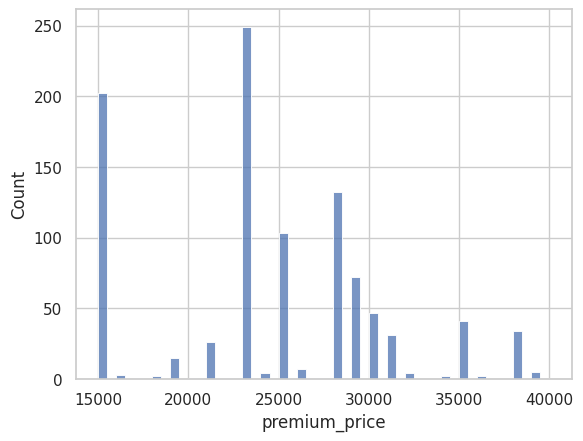

In [27]:
sns.histplot(df.premium_price, bins=50)